In [1]:
import pandas as pd
import numpy as np
import feather

from tqdm import tqdm

In [2]:
from outliers import remove_outliers

In [3]:
df_pays = feather.read_dataframe('data/df_pays_na_test.feather')

In [4]:
shops = df_pays.shop_id.unique()
shops = sorted(shops)

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [423]:
def season_init(y, m):
    s = np.zeros_like(y)

    mean = np.nanmean(y[:m])

    for i in range(m):
        if np.isnan(y[i]):
            if i > 0:
                tmp = (y[i - 1] + y[i + 1]) / 2
            else:
                tmp = y[i + 1]

            if np.isnan(tmp):
                tmp = 0.0

            s[i] = tmp - season_mean
        else:
            s[i] = y[i] - season_mean

    s[:m] = s[:m] - s[:m].mean()

    return s

In [412]:
def exponential_smoothing(y, alpha, beta, gamma, m):
    l = np.zeros_like(y)
    t = np.zeros_like(y)
    s = season_init(y, m)
    yfit = np.zeros_like(y)

    # init level and trend
    l[0] = y[0]
    yfit[0] = y[0]
    t[0] = 0.0

    alpha_ = 0.9
    beta_ = 0.5
    for i in range(1, m):
        if np.isnan(y[i]):
            y[i] = yfit[i - 1]

        l[i] = alpha_ * (y[i] - s[i]) + (1 - alpha_) * (l[i - 1] + t[i - 1])
        t[i] = beta_ * (l[i] - l[i - 1]) + (1 - beta_) * t[i - 1]

        yfit[i] = l[i] + t[i] + s[i]
        
    # do fitting / prediction
    for i in range(m, len(y)):
        if np.isnan(y[i]):
            y[i] = yfit[i - 1]

        l[i] = alpha * (y[i] - s[i - m]) + (1 - alpha) * (l[i - 1] + t[i - 1])
        t[i] = beta * (l[i] - l[i - 1]) + (1 - beta) * t[i - 1]
        s[i] = gamma * (y[i] - (l[i - 1] + t[i - 1])) + (1 - gamma) * (s[i - m])
        yfit[i] = l[i] + t[i] + s[i]
    
    return l, t, s, yfit

In [686]:
def first_not_null(y):
    idx_start = 0

    for yi in y:
        if np.isnan(yi):
            idx_start = idx_start + 1
        else:
            break

    return idx_start

In [626]:
import itertools

In [670]:
def calculate_nan_sizes(series):
    res = []

    for g, group in itertools.groupby(series.isnull()):
        s = len(list(group))
        if g == True:
            res.extend([0] * s)
        else:
            res.extend([s] * s)

    return pd.Series(res, index=series.index)

In [754]:
def exponential_smoothing_predict(l, t, s, alpha, beta, gamma, m, horizon):
    len_in = len(l)

    l = np.concatenate([l, np.zeros(horizon)])
    t = np.concatenate([t, np.zeros(horizon)])
    s = np.concatenate([s, np.zeros(horizon)])
    
    for i in range(len_in, len_in + horizon):
        prev = l[i - 1] + t[i - 1] + s[i - 1]

        l[i] = alpha * (prev - s[i - m]) + (1 - alpha) * (l[i - 1] + t[i - 1])
        t[i] = beta * (l[i] - l[i - 1]) + (1 - beta) * t[i - 1]
        s[i] = gamma * (prev - (l[i - 1] + t[i - 1])) + (1 - gamma) * (s[i - m])

    return l[-horizon:], t[-horizon:], s[-horizon:]

def fit_exp_smoothing(df_shop, alpha, beta, gamma, m):
    name_prefix = 'exp_smoothing_%0d_%0d_%0d_%d' % \
        (int(alpha * 100), int(beta * 100), int(gamma * 100), m)

    y_series = df_shop.pays_count.copy()
    is_not_nan_size = calculate_nan_sizes(y_series)
    y_series[(y_series.index < 7*2*3) & (is_not_nan_size < 7)] = np.nan
    y = y_series.values

    y_start = first_not_null(y)

    l, t, s, yfit = exponential_smoothing(y[y_start:].copy(), alpha, beta, gamma, m)

    df_shop.loc[y_start:, name_prefix + '_level'] = l
    df_shop.loc[y_start:, name_prefix + '_trend'] = t
    df_shop.loc[y_start:, name_prefix + '_season'] = s
    df_shop.loc[y_start:, name_prefix + '_fit'] = yfit

    df_shop[name_prefix + '_level_pred'] = np.nan
    df_shop[name_prefix + '_trend_pred'] = np.nan
    df_shop[name_prefix + '_season_pred'] = np.nan
    df_shop[name_prefix + '_fit_pred'] = np.nan

    biweek_max = df_shop.biweek_id.max()

    for w in range(biweek_max - 1, 0, -1):
        train_idx = df_shop.biweek_id == w
        test_idx = df_shop.biweek_id == (w - 1)

        df_train = df_shop[train_idx]
        l_train = df_train[name_prefix + '_level'].values
        t_train = df_train[name_prefix + '_trend'].values
        s_train = df_train[name_prefix + '_season'].values

        l_pred, t_pred, s_pred = exponential_smoothing_predict(l_train, t_train, s_train, 
                                            alpha, beta, gamma, m=m, horizon=14)
        y_pred = l_pred + t_pred + s_pred

        df_shop.loc[test_idx, name_prefix + '_level_pred'] = l_pred
        df_shop.loc[test_idx, name_prefix + '_trend_pred'] = t_pred
        df_shop.loc[test_idx, name_prefix + '_season_pred'] = s_pred
        df_shop.loc[test_idx, name_prefix + '_fit_pred'] = y_pred

    df_shop[name_prefix + '_level'] = df_shop[name_prefix + '_level'].shift(14)
    df_shop[name_prefix + '_trend'] = df_shop[name_prefix + '_trend'].shift(14)
    df_shop[name_prefix + '_season'] = df_shop[name_prefix + '_season'].shift(14)
    df_shop[name_prefix + '_fit'] = df_shop[name_prefix + '_fit'].shift(14)

    return name_prefix

In [688]:
df_shop = df_pays[df_pays.shop_id == 1189].reset_index(drop=1)
remove_outliers(df_shop)

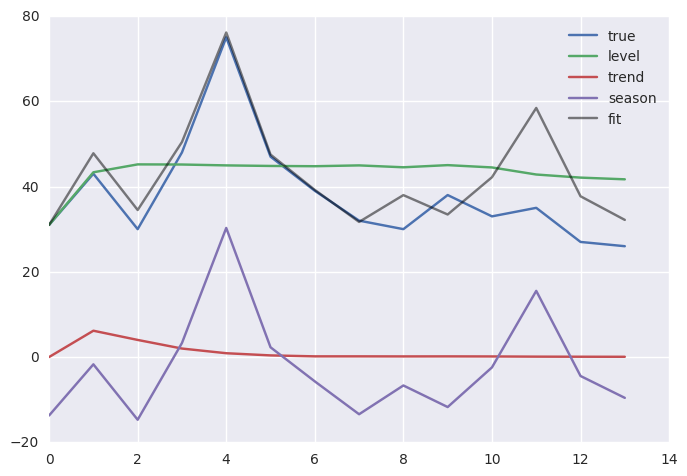

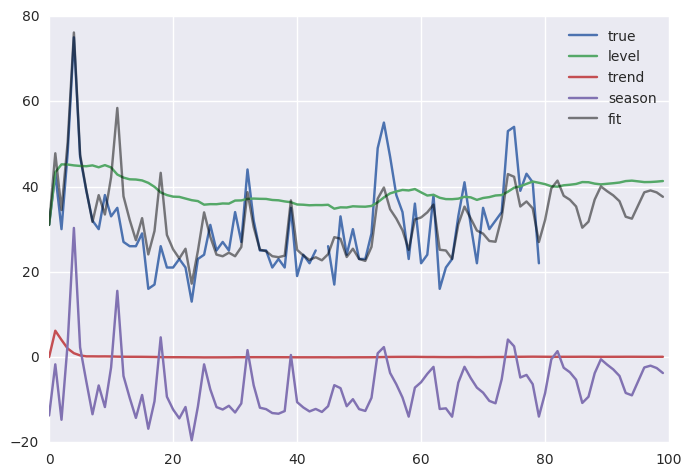

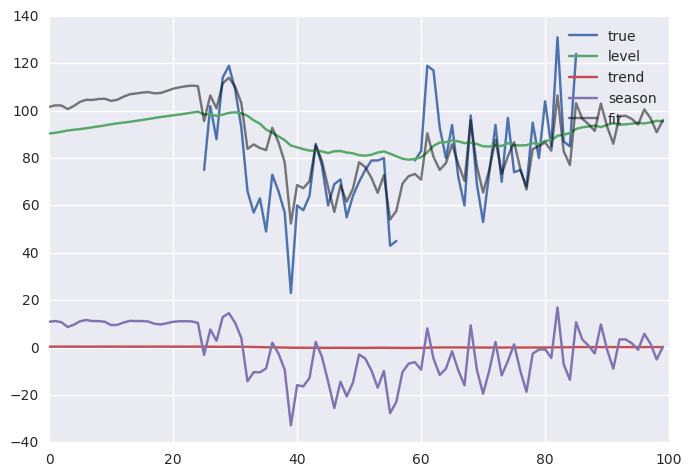

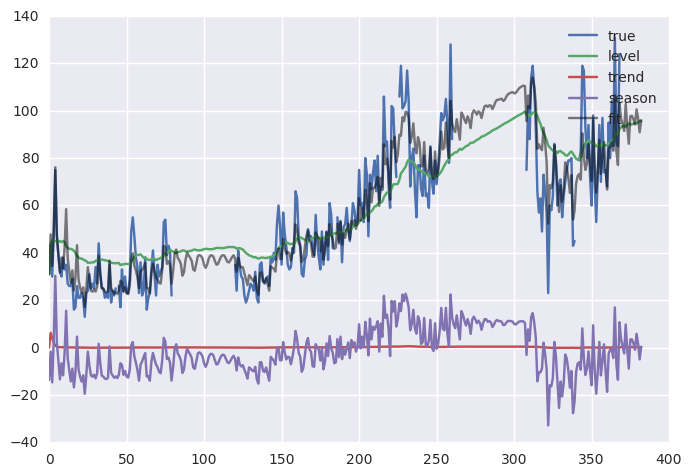

In [669]:
y = df_shop.pays_count.values
y_start = first_not_null(y)
y = y[y_start:].copy()

l, t, s, yfit = exponential_smoothing(y.copy(), alpha=0.045, beta=0.025, gamma=0.37, m=7)

plt.plot(y[:14], label='true')
plt.plot(l[:14], label='level')
plt.plot(t[:14], label='trend')
plt.plot(s[:14], label='season')
plt.plot(yfit[:14], label='fit', color='black', alpha=0.5)

plt.legend()

plt.show()


plt.plot(y[:100], label='true')
plt.plot(l[:100], label='level')
plt.plot(t[:100], label='trend')
plt.plot(s[:100], label='season')
plt.plot(yfit[:100], label='fit', color='black', alpha=0.5)

plt.legend()

plt.show()

plt.plot(y[-100:], label='true')
plt.plot(l[-100:], label='level')
plt.plot(t[-100:], label='trend')
plt.plot(s[-100:], label='season')
plt.plot(yfit[-100:], label='fit', color='black', alpha=0.5)

plt.legend()

plt.show()


plt.plot(y, label='true')
plt.plot(l, label='level')
plt.plot(t, label='trend')
plt.plot(s, label='season')
plt.plot(yfit, label='fit', color='black', alpha=0.5)

plt.legend()

plt.show()

In [689]:
df_shop = df_pays[df_pays.shop_id == 1189].reset_index(drop=1)
remove_outliers(df_shop)

In [690]:
fit_exp_smoothing(df_shop, alpha=0.045, beta=0.025, gamma=0.37, m=7)

'exp_smoothing_4_2_37_7'

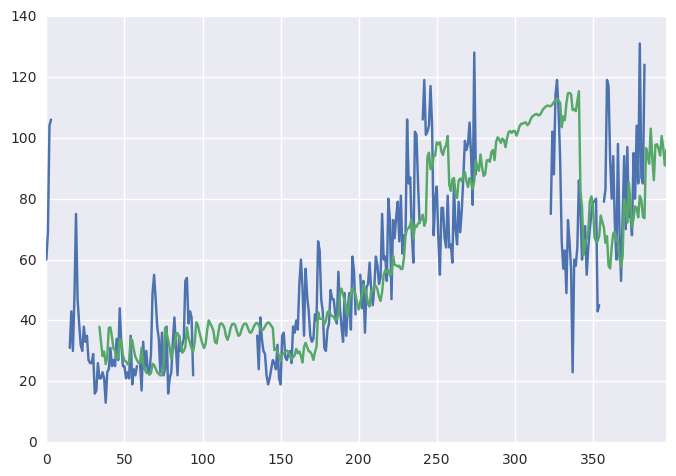

In [691]:
df_shop.pays_count.plot()
df_shop.exp_smoothing_4_2_37_7_fit_pred.plot()

In [567]:
def select_params(df_shop, m):
    scores = {}

    df_shop_copy = df_shop.copy()

    for a in [.01, .05]:
        for b in [.01, .05]:
            for c in [.01, .05, .1, .3, .5, .7]:
                pref = fit_exp_smoothing(df_shop_copy, alpha=a, beta=b, gamma=c, m=m)

                y = df_shop_copy.pays_count
                y_fit = df_shop_copy[pref + '_fit_pred']

                score = (y - y_fit).abs().mean()
                scores[(a, b, c)] = score

    return min(scores.items(), key=lambda x: x[1])

In [596]:
np.random.seed(10)
shops_sample = sorted(np.random.choice(shops, size=50, replace=False))

In [598]:
best_params = []
best_scores = []

for i in tqdm(shops_sample):
    df_shop = df_pays[df_pays.shop_id == i].reset_index(drop=1)
    remove_outliers(df_shop)

    b, s = select_params(df_shop, m=7)
    best_params.append(b)
    best_scores.append(s)

100%|██████████| 50/50 [02:43<00:00,  4.58s/it]


In [599]:
pd.DataFrame(best_params, columns=['a', 'b', 'g']).mean()

a    0.0444
b    0.0244
g    0.3732
dtype: float64

In [763]:
best_params = []
best_scores = []

for i in tqdm(shops_sample):
    df_shop = df_pays[df_pays.shop_id == i].reset_index(drop=1)
    remove_outliers(df_shop)

    b, s = select_params(df_shop, m=14)
    best_params.append(b)
    best_scores.append(s)

100%|██████████| 50/50 [02:42<00:00,  4.46s/it]


In [764]:
pd.DataFrame(best_params, columns=['a', 'b', 'g']).mean()

a    0.0452
b    0.0196
g    0.4462
dtype: float64

In [ ]:
dfs = []

for i in tqdm(shops):
    df_shop = df_pays[df_pays.shop_id == i].reset_index(drop=1)
    remove_outliers(df_shop)

    fit_exp_smoothing(df_shop, alpha=0.045, beta=0.025, gamma=0.37, m=7)
    fit_exp_smoothing(df_shop, alpha=0.045, beta=0.02, gamma=0.44, m=14)

    dfs.append(df_shop)

 59%|█████▉    | 1176/2000 [05:34<03:25,  4.00it/s]

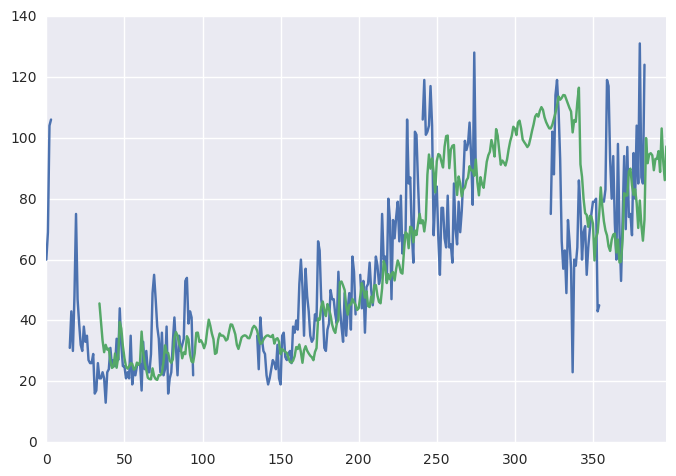

In [767]:
df = dfs[1189 - 1]
df.pays_count.plot()
df.exp_smoothing_4_2_44_14_fit_pred.plot()

In [768]:
truncated_dfs = []

for df in dfs:
    df = df.iloc[7 * 2 * 3:]
    truncated_dfs.append(df)

In [769]:
df_features = pd.concat(truncated_dfs).reset_index(drop=1)

In [770]:
for c in df_features.columns:
    if 'exp_smoothing' not in c:
        continue
    print(c)
    df_features.loc[df_features[c] <= 1, c] = 1

exp_smoothing_4_2_37_7_level
exp_smoothing_4_2_37_7_trend
exp_smoothing_4_2_37_7_season
exp_smoothing_4_2_37_7_fit
exp_smoothing_4_2_37_7_level_pred
exp_smoothing_4_2_37_7_trend_pred
exp_smoothing_4_2_37_7_season_pred
exp_smoothing_4_2_37_7_fit_pred
exp_smoothing_4_2_44_14_level
exp_smoothing_4_2_44_14_trend
exp_smoothing_4_2_44_14_season
exp_smoothing_4_2_44_14_fit
exp_smoothing_4_2_44_14_level_pred
exp_smoothing_4_2_44_14_trend_pred
exp_smoothing_4_2_44_14_season_pred
exp_smoothing_4_2_44_14_fit_pred


In [771]:
y = df_features.pays_count
y_pred = df_features.exp_smoothing_4_2_37_7_fit_pred
err = (y - y_pred).abs() / (y + y_pred)

In [772]:
pd.groupby(err, df_features.shop_id).mean().sort_values(ascending=False)

shop_id
1243    0.812018
413     0.674162
1808    0.652184
1514    0.541564
1855    0.531907
501     0.485086
1464    0.484887
1265    0.479153
1526    0.473027
5       0.430605
1873    0.404037
1799    0.394686
1556    0.387778
754     0.375729
1457    0.373869
1185    0.362633
1694    0.351610
295     0.345948
459     0.345032
1561    0.339692
1384    0.337788
768     0.332580
1214    0.331772
930     0.329857
561     0.329629
1968    0.318806
1875    0.315010
1548    0.313702
1904    0.312465
417     0.311567
          ...   
973     0.058038
667     0.057858
393     0.057537
378     0.057098
1445    0.056462
934     0.056100
1657    0.055920
838     0.055670
1916    0.055608
199     0.055282
1472    0.055255
1648    0.055117
1931    0.054766
950     0.054429
124     0.054191
1007    0.054153
1256    0.053774
831     0.052717
1019    0.052702
1663    0.052296
969     0.051907
1396    0.051720
600     0.051638
1584    0.049759
1962    0.049529
73      0.049193
1932    0.048773
58    

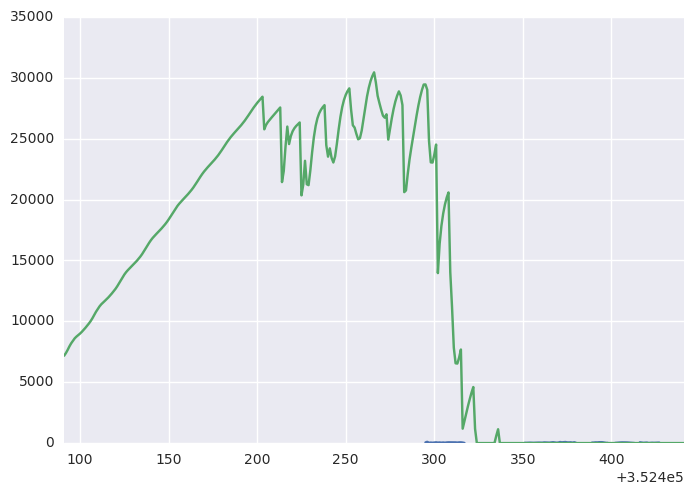

In [773]:
df = df_features[df_features.shop_id == 1243]
df.pays_count.plot()
df.exp_smoothing_4_2_44_14_fit_pred.plot()

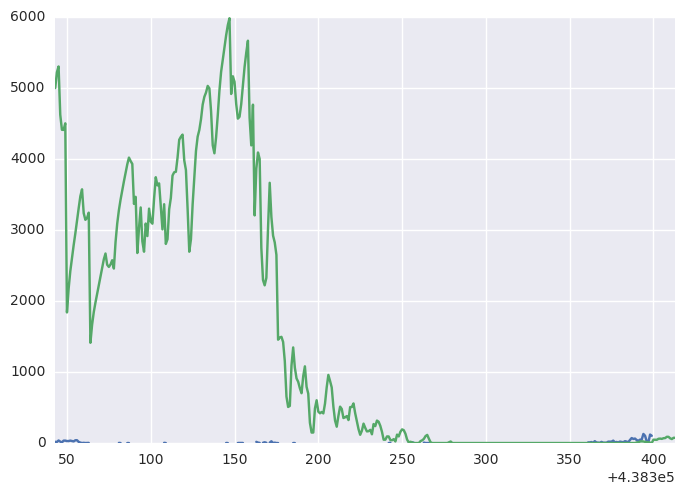

In [775]:
df = df_features[df_features.shop_id == 1526]
df.pays_count.plot()
df.exp_smoothing_4_2_44_14_fit_pred.plot()

In [776]:
err_nn = err[~err.isnull()]
err_nn.describe(percentiles=[0.95])

count    511920.000000
mean          0.129601
std           0.136173
min           0.000000
50%           0.089580
95%           0.390740
max           0.997501
dtype: float64

In [761]:
for c in df_features.columns:
    if 'exp_smoothing' not in c:
        continue
    if 'pred' in c:
        print(c)
        #df_features.loc[err >= 0.39, c] = np.nan

exp_smoothing_4_2_37_7_level_pred
exp_smoothing_4_2_37_7_trend_pred
exp_smoothing_4_2_37_7_season_pred
exp_smoothing_4_2_37_7_fit_pred


In [762]:
feather.write_dataframe(df_features, 'features/exp_smoothing_3.feather')